In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [2]:
print(use_cuda)

False


We check if we can use GPU, here I can not.

First we need an ODE solver, we take Euler to make it simple.


In [18]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

We also implement a superclass of parameterized dynamics function in the form of neural network with a couple useful methods.

First, one needs to be able to flatten all the parameters that the function depends on.

Second, one needs to implement a method that computes the augmented dynamics. This augmented dynamics depends on the gradient of the function wrt. its inputs and parameters. In order to not have to specify them by hand for every new architecture, we will use torch.autograd.grad method.

In [4]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back 
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

The code below incapsulates forward and backward passes of Neural ODE. We have to separate it from main torch.nn.Module because custom backward function can't be implemented inside Module, but can be implemented inside torch.autograd.Function. So this is just a little workaround.

This function underlies the whole Neural ODE method.

In [16]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

Wrap ode adjoint function in nn.Module for convenience.

In [5]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

### APPLICATION MNIST with convolutional neural network

In [6]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [3]:
def norm(dim):
    return nn.BatchNorm2d(dim)

def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [7]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [8]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [9]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw


Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw
Processing...
Done!





../torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [10]:
optimizer = torch.optim.Adam(model.parameters())

In [11]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) 
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [12]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [20]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Test Accuracy: 58.470%
Training Epoch 1...


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Train loss: 0.13621
Testing...



Test Accuracy: 98.430%
Training Epoch 2...



Train loss: 0.05000
Testing...



Test Accuracy: 99.000%
Training Epoch 3...



Train loss: 0.03702
Testing...



Test Accuracy: 99.040%
Training Epoch 4...



Train loss: 0.03053
Testing...



Test Accuracy: 99.220%
Training Epoch 5...



Train loss: 0.02603
Testing...



Test Accuracy: 98.690%


<Figure size 648x360 with 0 Axes>

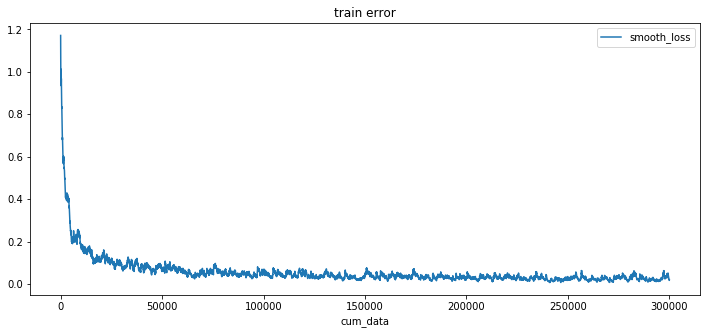

In [22]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")
plt.show()

With 5 epoch we reach a 98.69% accuracy but the previous epoch had a better score, the training was pretty slow but it's normal considering it couldn't use my GPU. 

We proved that this method fits very well with conventional networks.